# Stroke Prediction

In [1]:
import os
import kaggle
import math
import pandas as pd
import numpy as np
import warnings
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency, ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    LabelEncoder,
)
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    make_scorer,
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from utils.functions import *

params = {
    "figure.figsize": (6, 4),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "grid.alpha": 0.3,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.precision", 2)

# Dataset Cleaning

The main objectives for this part of the notebook are:

- Get familiar with the dataset.
- Discover data quality issues.
- Address the data quality issues.

15% of the data will be set aside for an unbiased assessment of the model's performance at the end of the project.

In [2]:
dataset_path = "fedesoriano/stroke-prediction-dataset"
if not os.path.exists("healthcare-dataset-stroke-data.csv"):
    kaggle.api.dataset_download_files(dataset_path, path="./", unzip=True)
patients_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")
patients, patients_holdout_test = train_test_split(
    patients_raw,
    test_size=0.15,
    random_state=5,
    stratify=patients_raw["stroke"],
)

## Data Profiling

The dataset is a single CSV file.

### Table Contents

In [3]:
rows, columns = patients.shape
print(f"{rows} rows and {columns} columns.")
patients.columns = patients.columns.str.replace("_", " ").str.title()
patients.rename(columns={"Bmi": "BMI"}, inplace=True)
patients.head()

4343 rows and 12 columns.


,Id,Gender,Age,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Avg Glucose Level,BMI,Smoking Status,Stroke
3754,18943,Male,26.00,0,0,No,Govt_job,Rural,76.74,29.80,Unknown,0
1874,24066,Female,45.00,0,0,Yes,Private,Urban,72.65,25.60,Unknown,0
1677,48722,Female,54.00,0,0,Yes,Private,Urban,75.09,38.90,formerly smoked,0
4032,46343,Female,79.00,0,0,Yes,Private,Urban,71.46,33.40,Unknown,0
2811,33247,Male,20.00,0,0,No,Private,Rural,88.47,28.10,smokes,0


Observations:

- The dataset contains 10 predictor variables and 1 target variable of weather or not a person had a stroke.
- There is an ID column for person identification.
- There are 4343 entries in the dataset.
- The dataset has 7 binary categorical features, 3 continuous numerical features and a binary target.

### Missing Values

In [4]:
print(patients.isnull().sum())
missing_bmi = patients["BMI"].isnull().sum()
total_patients = len(patients)
missing_bmi_percentage = round((missing_bmi / total_patients) * 100, 1)

print(
    f"Percentage of missing values in BMI feature: {missing_bmi_percentage}%"
)

Id                     0
Gender                 0
Age                    0
Hypertension           0
Heart Disease          0
Ever Married           0
Work Type              0
Residence Type         0
Avg Glucose Level      0
BMI                  169
Smoking Status         0
Stroke                 0
dtype: int64
Percentage of missing values in BMI feature: 3.9%


Observations:
- Body mass index has 3.9% of all vlalues missing.
  
Impact:
- To decide on what to do with this issue, I will plot and compare stroke distributions for missing values and the rest of the dataset.

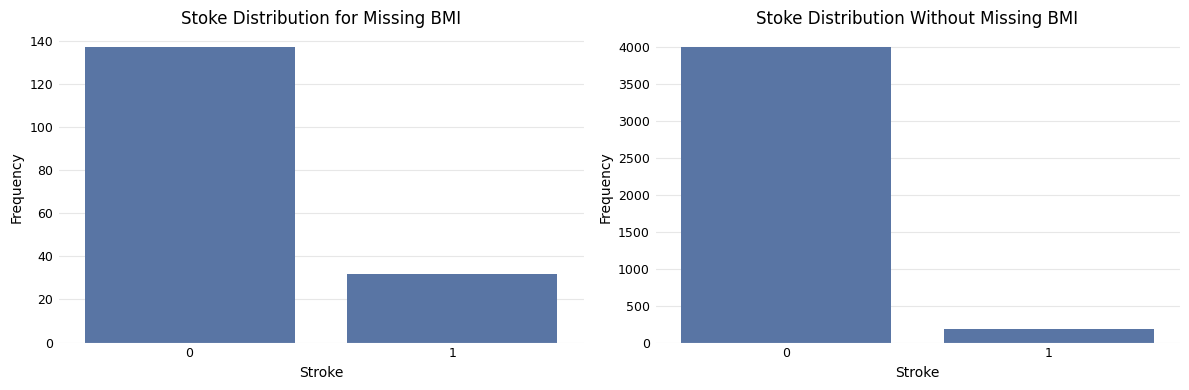

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=patients[patients["BMI"].isna()], x="Stroke", zorder=2, ax=axes[0])
axes[0].set_title("Stoke Distribution for Missing BMI")
axes[0].set_ylabel("Frequency")
sns.countplot(data=patients.dropna(), x="Stroke", zorder=2, ax=axes[1])
axes[1].set_title("Stoke Distribution Without Missing BMI")
axes[1].set_ylabel("Frequency")
plt.tight_layout()

Observations:
- Patients with missing BMI values are significantly more likely to have had a stroke compared to those without missing values.

Impact:
- Imputing values for this feature would introduce bias, as the missingness itself is informative and there is no apparent reason why instances with missing information would be mopre predictive of a stroke. In a real-world project it would be important to understan why this pattern occurs, but since I cannot determine this, I will remove these instances without adding potentially biasing imputations.

In [6]:
patients = patients.dropna()

### Duplicates

In [7]:
print(f'Duplicates by ID number: {patients.duplicated(subset="Id").any()}')
print(f'Exact duplications: {patients.drop(columns="Id").duplicated().any()}')

Duplicates by ID number: False
Exact duplications: False


Observations:
- No duplicates.

Impact:
- ID is no longer useful.

In [8]:
patients.drop(columns="Id", inplace=True)

### Data Types

In [9]:
patients.dtypes

Gender                object
Age                  float64
Hypertension           int64
Heart Disease          int64
Ever Married          object
Work Type             object
Residence Type        object
Avg Glucose Level    float64
BMI                  float64
Smoking Status        object
Stroke                 int64
dtype: object

Observations:

- Categorical features are stored as objects.
- Some features are binary categorical, but are stored as int64.

Impact:
- For performance and ease of management, objects and integer types that have two values will be converted to categories.

In [10]:
patients = patients.apply(
    lambda col: col.astype("category") if col.dtype == "object" else col
)
binary_columns = ["Hypertension", "Heart Disease", "Smoking Status", "Stroke"]
patients[binary_columns] = patients[binary_columns].apply(
    lambda col: col.astype("category")
)
columns_with_categories_to_rename = ["Hypertension", "Heart Disease", "Stroke"]
for column in columns_with_categories_to_rename:
    patients[column] = patients[column].cat.rename_categories({0: "No", 1: "Yes"})

### Entry Errors and Anomalies of Numeric Variables

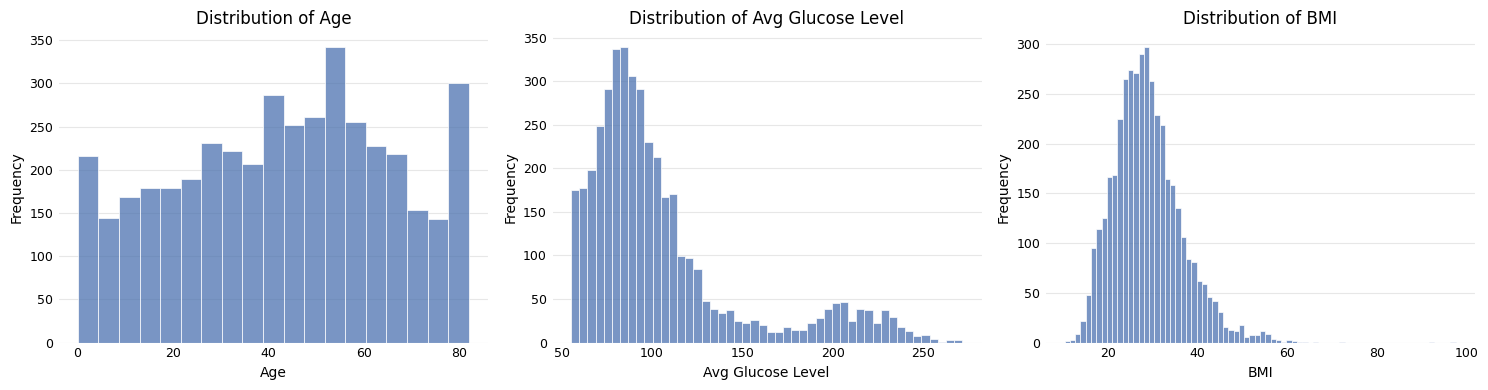

Instances of BMI above 60 kg/m²: 11
Instances of Avg Glucose Level above 250 mg/dL: 19


In [11]:
plot_numeric_distributions(patients)
print(f'Instances of BMI above 60 kg/m²: {len(patients[patients["BMI"] > 60])}')
high_glucose_count = len(patients[patients["Avg Glucose Level"] > 250])
print(
    f"Instances of Avg Glucose Level above 250 mg/dL: {high_glucose_count}"
)

Observations:
- Most BMI values seem to range from about 15 to 60 kg/m². This is typical human BMI, which covers normal weight, overweight, and various classes of obesity.
- BMI values above 60, especially those approaching 100, are suspicious - 60 is already an extreme obesity.
- Average glucose levels above 250 mg/dL are also suspect, which indicates severe uncontrolled diabetes. Such high values are possible, but relatively rare.

Impact:
- High average glucose levels, while uncommon, are plausible given the dataset's context, such as age and medical conditions. I could do an investigation into this topic, but this would require a deeper medical understanding of weather or not this is possible based on other feature values and this would require too much time to research.
- Further look into the cases where BMI is above 60 kg/m².

In [12]:
display(patients[patients["BMI"] >= 60].head(15))
print(f'Instances of BMI above 65 kg/m²: {len(patients[patients["BMI"] > 65])}')

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Avg Glucose Level,BMI,Smoking Status,Stroke
270,Female,57.00,Yes,No,Yes,Private,Rural,129.54,60.90,smokes,No
1559,Female,53.00,No,No,Yes,Private,Rural,72.63,66.80,Unknown,No
4838,Female,51.00,No,No,Yes,Private,Urban,107.72,60.90,Unknown,No
544,Male,42.00,No,No,Yes,Private,Rural,210.48,71.90,never smoked,No
466,Female,61.00,Yes,No,Yes,Private,Rural,170.05,60.20,smokes,No
3825,Female,52.00,No,No,Yes,Private,Rural,118.46,61.60,smokes,No
2764,Female,24.00,No,No,Yes,Private,Urban,85.55,63.30,never smoked,No
2128,Male,17.00,Yes,No,No,Private,Rural,61.67,97.60,Unknown,No
4188,Female,27.00,No,No,Yes,Private,Rural,57.96,64.40,never smoked,No
4209,Male,38.00,Yes,No,Yes,Private,Rural,56.90,92.00,never smoked,No


Instances of BMI above 65 kg/m²: 4


Observations:
- BMIs of 71.9, 92.0, and 97.6 are clearly errors and impossible for humans, even in severe obesity cases. Such values indicate data entry errors or other issues.
- Determining the plausibility of other high values is more difficult, requiring further research or consultation with domain experts. I will not delve into this topic deeper.
  
Impact:
- Set a threshold of 65 kg/m² and remove all data above this threshold, totaling 4 instances.

In [13]:
patients = patients[(patients["BMI"] <= 65)]

### Entry Errors and Anomalies of Categorical Variables

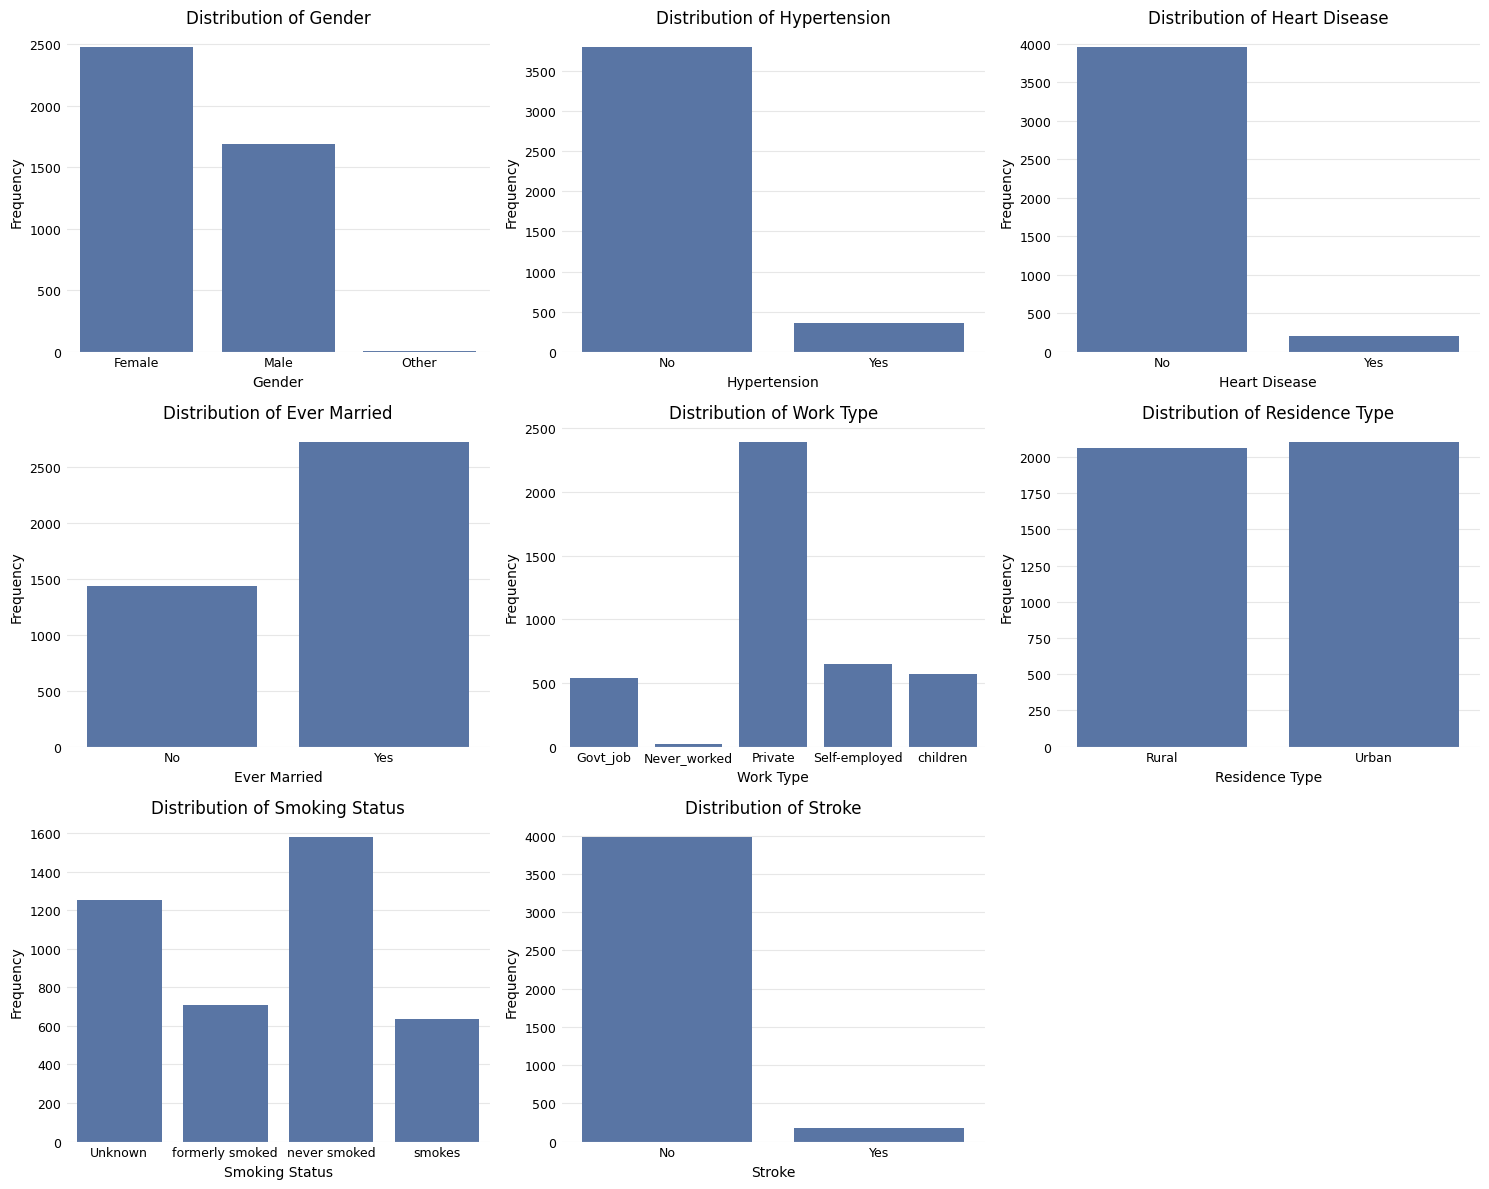

Number of times the "Other" gender appears in the dataset: 1
Number of times the "Never_worked" appears in the dataset: 18


In [14]:
plot_categorical_distributions(patients)
other_gender_count = len(patients[patients["Gender"] == "Other"])
never_worked_count = len(patients[patients["Work Type"] == "Never_worked"])
print(
    f'Number of times the "Other" gender appears in the dataset: {other_gender_count}'
)
print(
    f'Number of times the "Never_worked" appears in the dataset: {never_worked_count}'
)

Observations:
- Gender has a single instance of an "Other" category.
- There is a small category of people who have never worked.
- A lot of patients have an "Unknown" status for their smoking, effectively this is a  missing information.
  
Impact:
- Remove the "Other" category as a single instance does not provide enough data for the model to learn meaningful patterns.
- Further check the distributions of the two categories in question.

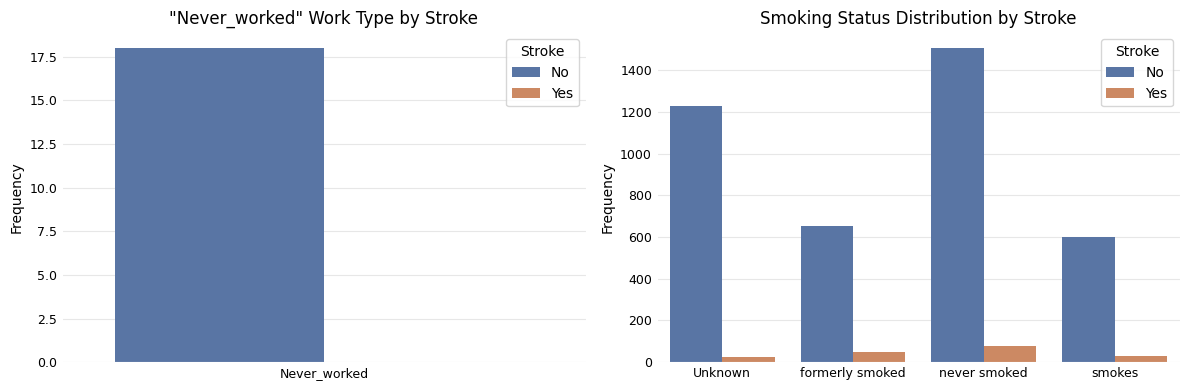

In [15]:
patients = patients[patients["Gender"] != "Other"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(
    data=patients,
    x="Work Type",
    hue="Stroke",
    order=["Never_worked"],
    zorder=2,
    ax=axes[0],
)
axes[0].set_title('"Never_worked" Work Type by Stroke')
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel(None)
sns.countplot(data=patients, x="Smoking Status", hue="Stroke", zorder=2, ax=axes[1])
axes[1].set_title("Smoking Status Distribution by Stroke")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel(None)
plt.tight_layout()

Observations:
- Patients who never worked had no strokes. This is an accidental trend, which may teach the model to assosiate this category with not having a stroke.
- Smoking status by stroke does not seem unusual.

Impact:
- Drop entries with "Never_worked".
- For the "Unknown" category, I will keep it as is. This is an acceptable way to handle missing categorical information. It may be possible to find a better approach by trying different imputation methods such as KNN imputation, clustering, or mode imputation. This would take up time as I would also have to do hyperparameter tuning for each imputation method and I will not spend time on this.

In [16]:
patients = patients[patients["Work Type"] != "Never_worked"]

## Data Preparation Pipeline

I will create a data preparation pipeline, to apply to the holdout test set and any new data in general with modifications made during data cleaning section.

In [17]:
def data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning and preparation pipeline.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data to be cleaned and prepared.

    Returns:
        pd.DataFrame: DataFrame with various appropriate transformations applied.
    """
    df_prepared = df.copy()
    df_prepared.columns = df_prepared.columns.str.replace("_", " ").str.title()
    df_prepared.rename(columns={"Bmi": "BMI"}, inplace=True)
    df_prepared = df_prepared.dropna()
    df_prepared.drop(columns="Id", inplace=True)
    df_prepared = df_prepared.apply(
        lambda col: col.astype("category") if col.dtype == "object" else col
    )
    binary_columns = ["Hypertension", "Heart Disease", "Smoking Status", "Stroke"]
    df_prepared[binary_columns] = df_prepared[binary_columns].apply(
        lambda col: col.astype("category")
    )
    columns_with_categories_to_rename = ["Hypertension", "Heart Disease", "Stroke"]
    for column in columns_with_categories_to_rename:
        df_prepared[column] = df_prepared[column].cat.rename_categories(
            {0: "No", 1: "Yes"}
        )
    df_prepared = df_prepared[(df_prepared["BMI"] <= 65)]
    df_prepared = df_prepared[df_prepared["Gender"] != "Other"]
    df_prepared = df_prepared[df_prepared["Work Type"] != "Never_worked"]
    return df_prepared

## Summary

During the data cleaning process, several issues were identified, leading to these actions:

- Column names were standardized for consistency, and appropriate columns were converted to categorical data type for efficiency.
- A few records had missing BMI values; these entries were eliminated to reduce bias.
- The patient ID column was removed, as it does not contribute to prediction accuracy.
- BMI values exceeding 65 were identified as false and subsequently removed.
- A single occurrence of a category in a gender feature was removed for simplification.
- "Never_worked" category has been dropped as it may bias the model in assosiating this status with no having a stroke.
- The "Unknown" category in the smoking status feature is missing data. This category will be retained without modification.

Additional considerations include exploring various imputation techniques, such as KNN or clustering, to enhance the handling of the "Unknown" category. Also, verify the values of Avg Glucose Level and investigate why patients with missing BMI information are much more likely to have a stroke. It may be possible to further clean the data if I had more information about this topic and could recognize unlikely or impossible attribute combinations.

# EDA

The main objectives for this part of the notebook are:
- Explore the dataset through multivariate analysis.
- Further clean the data.
- Extract relevant insights.
- Identify feature engineering opportunities.

## Target Variable

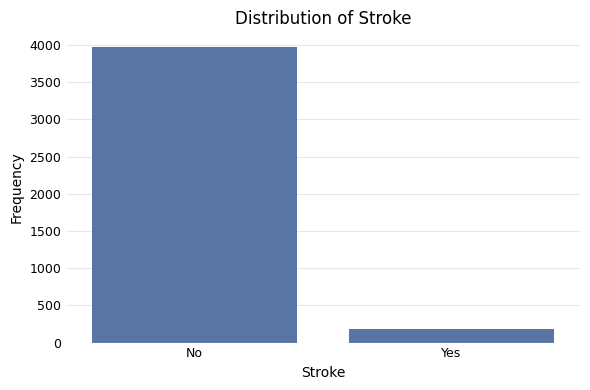

In [18]:
sns.countplot(data=patients, x="Stroke", zorder=2)
plt.title("Distribution of Stroke")
plt.ylabel("Frequency")
plt.tight_layout()

Observations:
- The target feature is imbalanced.

Impact:
- Test different ways of addressing when building a model.

## Relationships Between Target and Predictors

Detailed descriptions of all associations will be provided in the "Insights" sub-section at the end of EDA.

### Hypothesis Test Selection for Numeric Predictors

Let's see if it is appropriate to use the Mann–Whitney U hypothesis test. I will be checking if the third assumption for the Mann-Whitney U test—that the two samples have similar distributions—is violated or not.

Null Hypothesis (H0): The distributions of the two independent samples are equal.

Alternative Hypothesis (H1): The distributions of the two independent samples are not equal.

We will use a significance level of 0.05 to test these hypotheses. If the p-value calculated from the Kolmogorov-Smirnov test is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

Example: In the case of age and stroke (shown below), the p-value is below the significance level. We reject the null hypothesis and conclude that distributions are significantly different between the groups with and without stroke.

In [19]:
test_distribution_similarity(patients, "Stroke")

Age - Stroke:
Kolmogorov-Smirnov test statistic: 0.54, p-value: 0.00

Avg Glucose Level - Stroke:
Kolmogorov-Smirnov test statistic: 0.26, p-value: 0.00

BMI - Stroke:
Kolmogorov-Smirnov test statistic: 0.18, p-value: 0.00



Observations:
- Given the p-values are all 0.00, the distributions of age, average glucose level, and BMI are significantly different between the groups with and without a stroke. This indicates that the two samples do not have similar distribution shapes.

Impact:

- Mann-Whitney U test assumtion is violated.
- The only remaining available hypothesis test is a bootstrap.

### Numeric Predictors

Bootstrap hypothesis test for the difference of medians between the two groups:

Null Hypothesis (H0): There is no association between the predictor and the target variable.

Alternative Hypothesis (H1): There is an association between the predictor and the target variable.

Significance level of 0.05 will be used to test these hypotheses. If the p-value calculated from the bootstrap test for the difference in medians is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

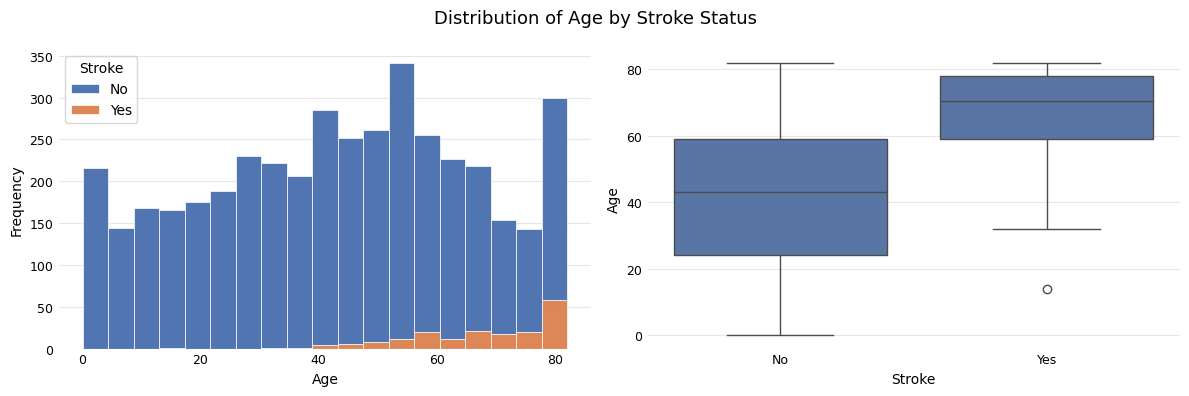

Age - Stroke:
Bootstrap hypothesis test p-value: 0.00


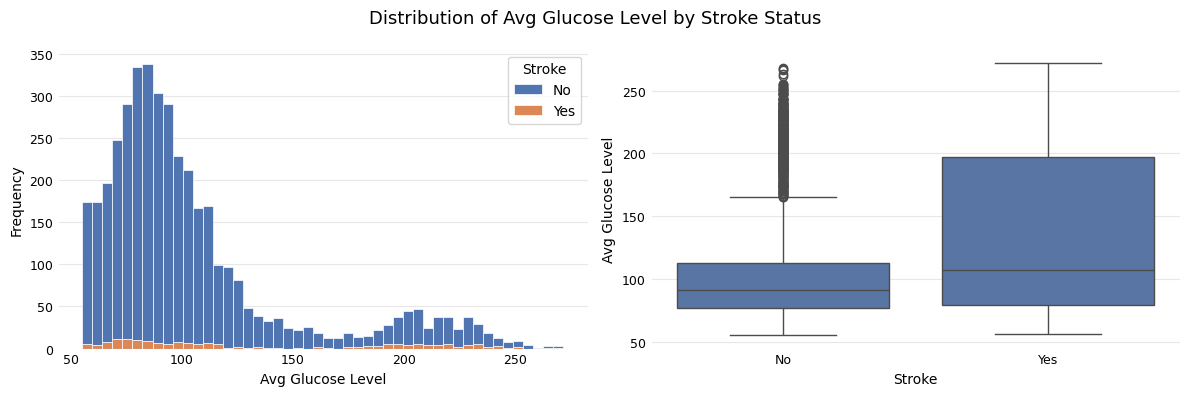

Avg Glucose Level - Stroke:
Bootstrap hypothesis test p-value: 0.00


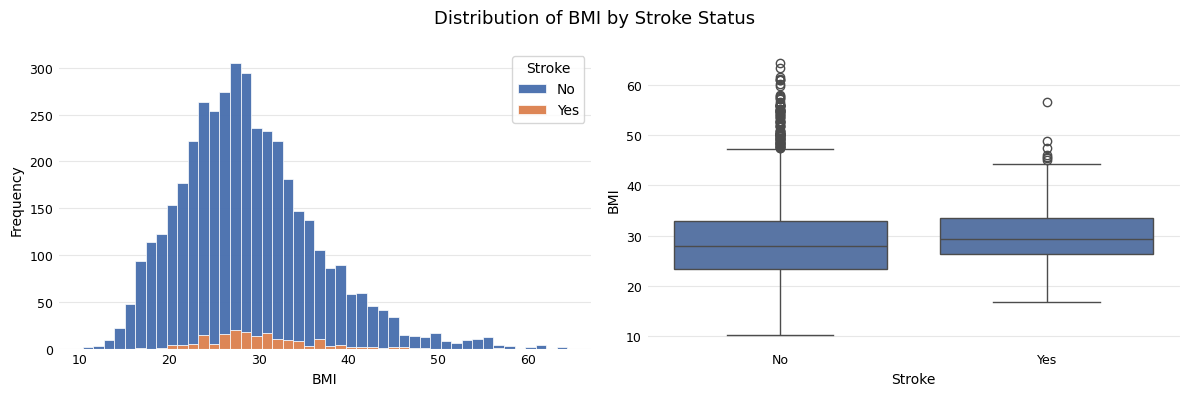

BMI - Stroke:
Bootstrap hypothesis test p-value: 0.02


In [20]:
numeric_relationships(patients, "Stroke")

Observations:

- All numeric predictors have a statistically significant assosiation with stroke.
- By far the strongest assosiation with stroke is age.

### Categorical Predictors

Assumptions for the Chi-square hypothesis test:

- Independence: Each patient has a unique ID, and one patient's condition should be unrelated to others.
- Expected Frequency at least 5: This condition is valid for relationships except for the ones with work type, making the test results for the assosiation between work type and stroke possibly invalid. The counts in each group are visible from the bar plots on the left.
- Categorical Data: Our data is categorical.
- Adequate Sample Size: Since the second assumption (Expected Frequency) is met, the fourth assumption is generally not a concern.

The hypotheses and significance level will be the same as for the bootstrap hypothesis test above.

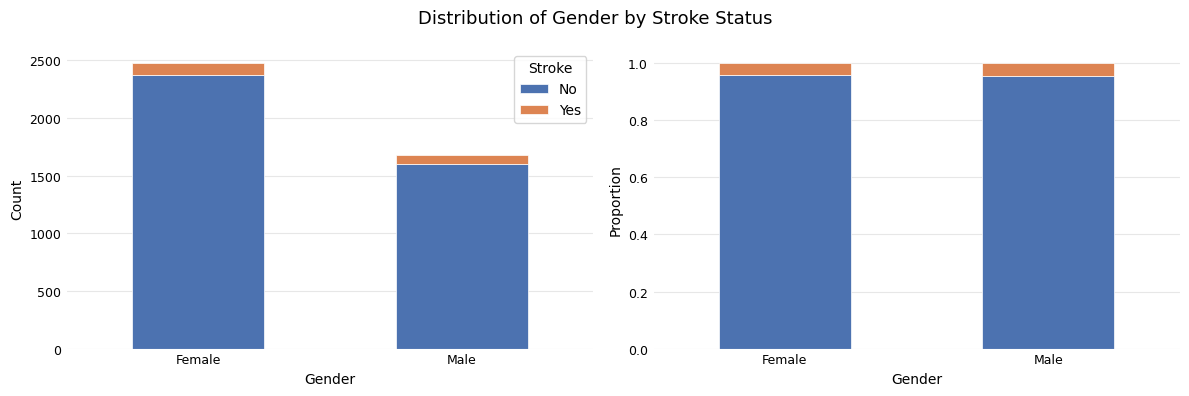

Gender - Stroke:
Chi-Square test p-value: 0.79



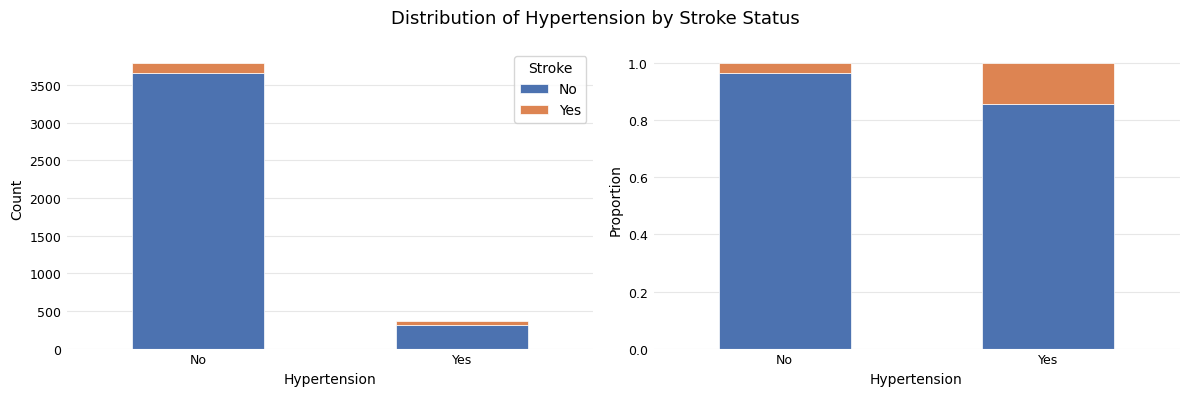

Hypertension - Stroke:
Chi-Square test p-value: 0.00



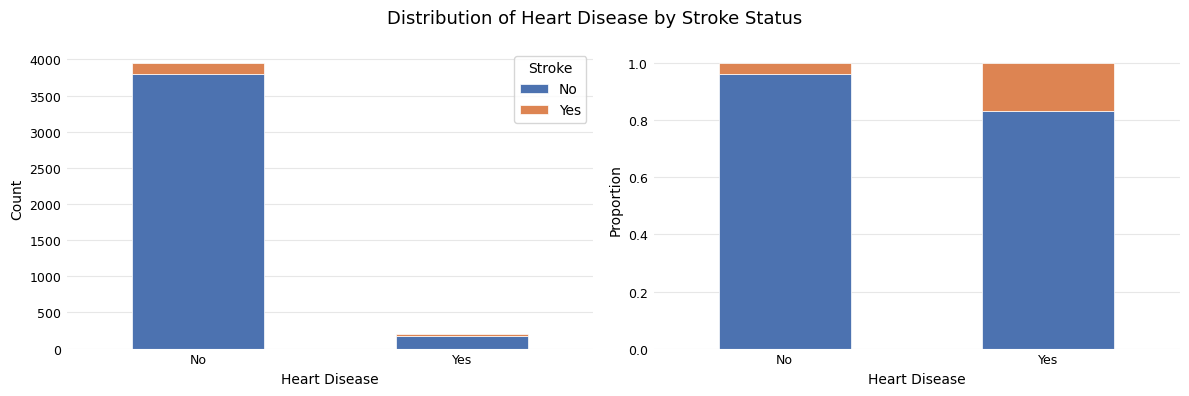

Heart Disease - Stroke:
Chi-Square test p-value: 0.00



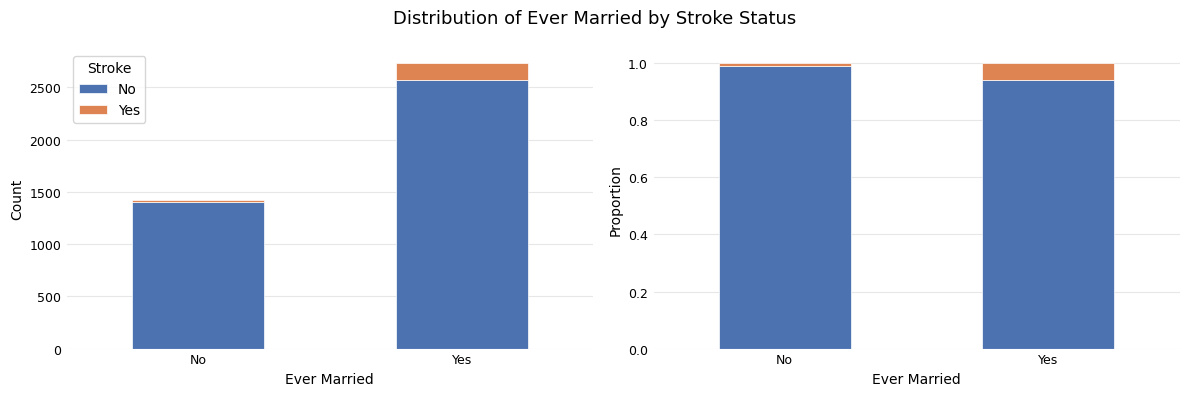

Ever Married - Stroke:
Chi-Square test p-value: 0.00



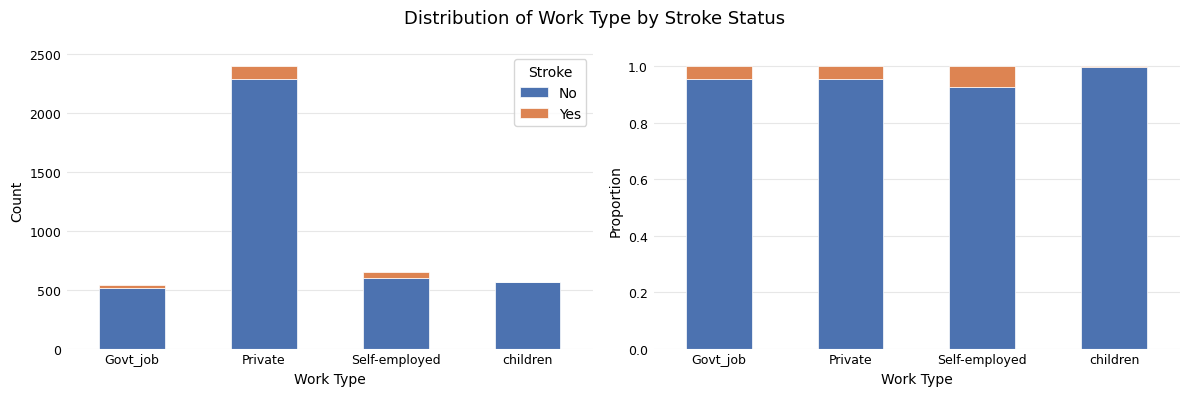

Work Type - Stroke:
Chi-Square test p-value: 0.00



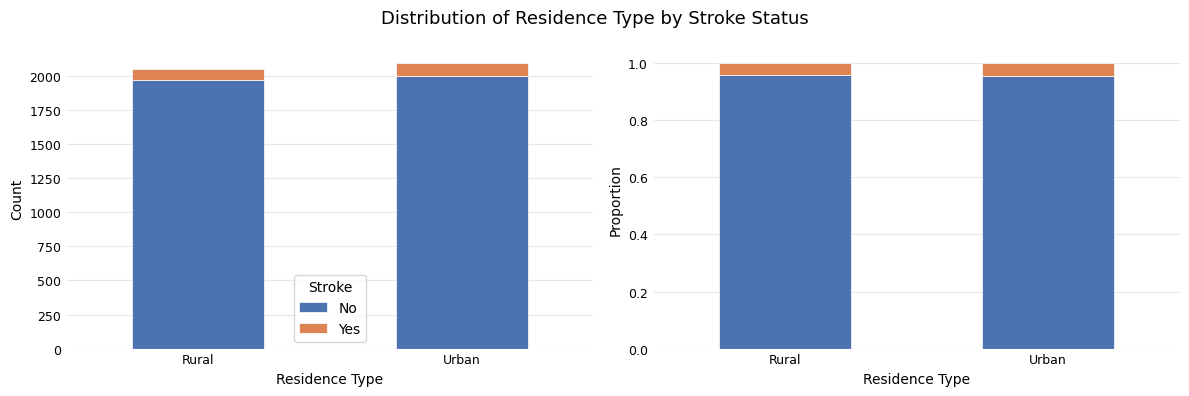

Residence Type - Stroke:
Chi-Square test p-value: 0.80



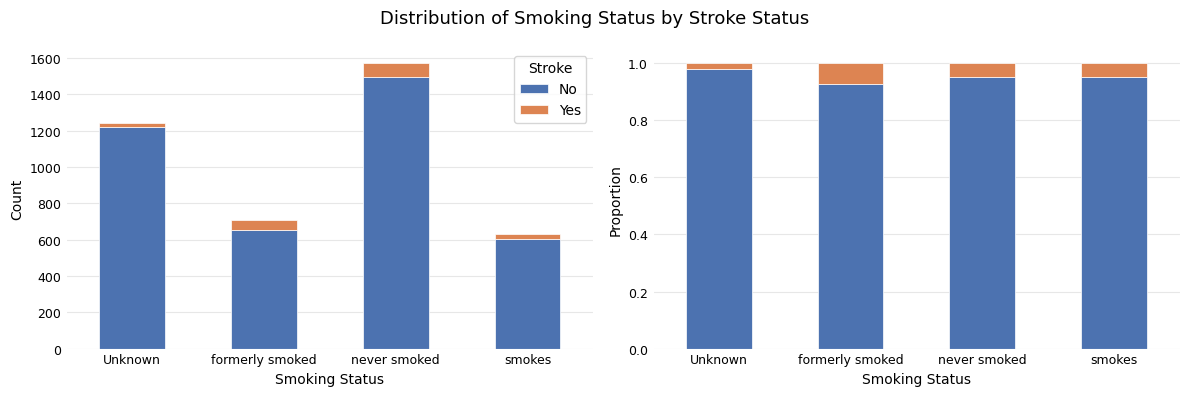

Smoking Status - Stroke:
Chi-Square test p-value: 0.00



In [21]:
categorical_relationships(patients, "Stroke")

Observations:

- All categorical variables except for gender and residence type are statistically significantly associated with stroke.
- For work type and smoking status, individual post-hoc tests (Chi-square tests) should be performed for each pair of groups to determine which specific differences are statistically significant. I will not analyze these associations further.

## Relationships Between Predictors

The Phik ($\phi_K$) correlation coefficient measures the strength of association between variables, similar to the Pearson correlation for continuous data, but it is adapted for categorical and mixed data types (it converts numeric variables into categorical ones). $\phi_K$ values range from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. This measure does not indicate the direction of the influence.

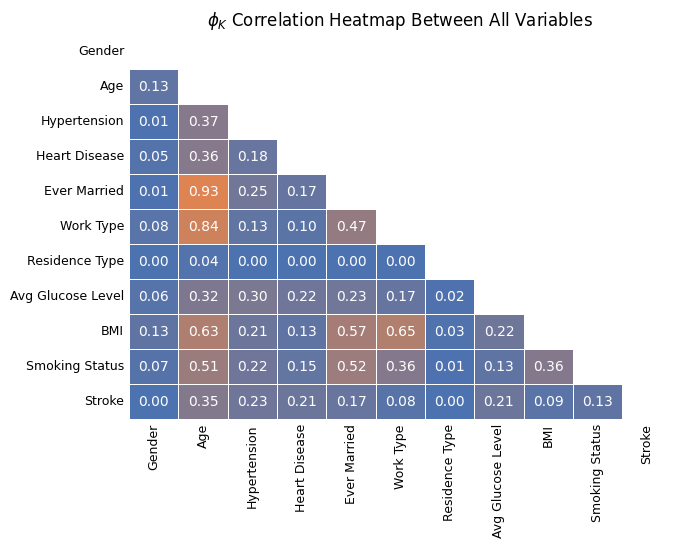

In [22]:
phik_heatmap(patients)

Observations:
- As we've seen before, the strongest association with stroke is age, while other associations are weaker.
- There is probably no multicollinearity, but age shows multiple high correlations.

Impact:
- Age, hypertension, heart disease, and average glucose level have the strongest association with stroke and will be used to create new features.
- Check if multicollinearity exists in the data, as it can affect the prediction accuracy of SVM, KNN, and linear models types.

VIF measurement to detect multicollinearity:

In [23]:
vif(patients, "Stroke")

,Feature,VIF
0,const,17.89
1,Age,4.52
2,Avg Glucose Level,1.07
3,BMI,1.47
4,Gender_Male,1.03
5,Hypertension_Yes,1.10
6,Heart Disease_Yes,1.07
7,Ever Married_Yes,1.91
8,Work Type_Private,2.34
9,Work Type_Self-employed,1.90


Observations:

- No multicollinearity detected, as no feature has a VIF above 5.

## Prevalence of Strokes Among Individuals with All Risk Factors

From our features, the real-world predictors of stroke are: age, hypertension, heart disease, average glucose level (related to diabetes), BMI, and smoking status. It would be interesting to see if individuals with these traits had a stroke according to our data. Lets select this information:

For the numeric variables:

- Age: We observed that all strokes occurred above the age of 40.
- Average Glucose Level and BMI: There was no clear pattern as these variables changed and it is not unclear what specific values from these variables to selcet.
  
For the categorical variables:

- Hypertension and Heart Disease: We can easily select the risk category.
- Smoking Status: The relationship looked odd. Only former smokers had a higher risk of stroke, while current smokers had the same risk as non-smokers. Therefore, I would not include this information.

This means we are left with only age, hypertension, and heart disease as predictors.

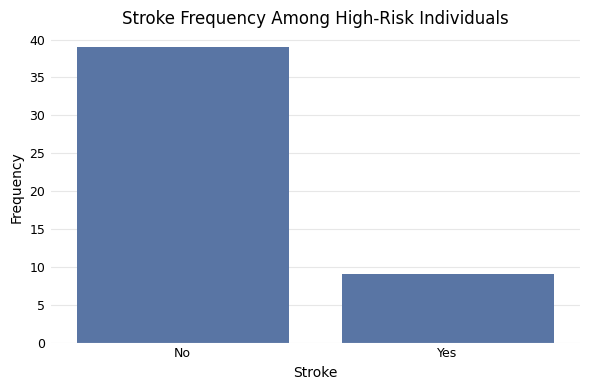

In [24]:
risk_group = patients[
    (patients["Age"] > 40)
    & (patients["Hypertension"] == "Yes")
    & (patients["Heart Disease"] == "Yes")
]
sns.countplot(data=risk_group, x="Stroke", zorder=2)
plt.ylabel("Frequency")
plt.title("Stroke Frequency Among High-Risk Individuals")
plt.tight_layout()

Observations:
- The proportion of people who had strokes with the risk factors is higher than among the general population, as visualized at the start of the EDA.
- Many individuals who could be expected to have had a stroke did not experience one. This suggests that our model may not be effective at predicting strokes, as it is not possible to make accurate predictions from the data.

## Additional Data Cleaning and Processing After Machine Learning

After applying machine learning, the best-performing model was logistic regression with relatively low scores of: PR AUC: 0.1, ROC AUC: 0.84, F1: 0.2, Precision: 0.11, Recall: 0.82, Validation Accuracy: 0.71, and Training Accuracy: 0.71. Notably, "Work Type - children" was incorrectly identified as the second best indicator for having a stroke. To address these issues, additional data cleaning was performed to simplify the model and reduce noise in the data.

Steps taken:
- Filter out all data points with age below 35, as no person had a stroke in this age range.
- Merge the former smoker and current smoker categories into a general "smoked" category to better reflect the fact that smoking is a known contributor to strokes.

Instances with "Unknown" smoking status were also removed. This resulted in an increase of only one or two hundredths in some scores for certain models. Feature importance plots were perhaps a bit more reflective of real-world associations, but the data loss was large, so this change was reversed.

Size of original dataframe: 4151 instances
Size of dataframe after discarding age below 35: 2596 instances


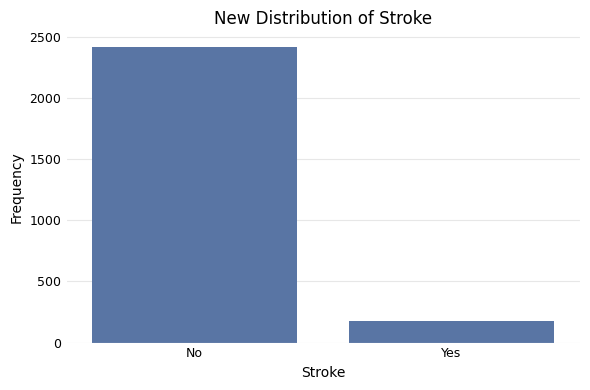

In [25]:
def additional_data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Additional data cleaning and preparation pipeline.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data to be cleaned and prepared again.

    Returns:
        pd.DataFrame: DataFrame with various appropriate transformations applied.
    """
    df_prepared = df.copy()
    print(f"Size of original dataframe: {len(df_prepared)} instances")
    df_prepared = df_prepared[df_prepared["Age"] > 35]
    print(
        f"Size of dataframe after discarding age below 35: {len(df_prepared)} instances"
    )
    df_prepared["Smoking Status"] = df_prepared["Smoking Status"].replace(
        {"formerly smoked": "smoked", "smokes": "smoked"}
    )
    return df_prepared


patients = additional_data_preparation(patients)
sns.countplot(data=patients, x="Stroke", zorder=2)
plt.title("New Distribution of Stroke")
plt.ylabel("Frequency")
plt.tight_layout()

Observations:
- The proportion of strokes is higher, but laber inbalance is still large.
- This information is not shown, but all "Work Type - children" data is gone.
- This change increased model effectiveness.

## Insights

Statistically significant predictors of stroke supported by domain knowledge:

- Old age is the strongest factor for having a stroke.
- People with high blood pressure are more likely to have a stroke.
- Patients with heart disease are more likely to have a stroke.
- People with high glucose levels are more likely to have a stroke.
- Individuals with higher body fat are more likely to have a stroke.

Statistically significant associations not supported by domain knowledge:

- People who are married are more likely to have a stroke. There is no evidence that being married increases the risk of stroke; it may actually provide protective benefits.

No statistically significant associations:

- No association between gender and stroke. This is a nuanced connection, with men having a higher risk at younger ages and women having a higher risk at older ages. Women also face unique risk factors such as pregnancy and hormonal changes.
- Residence type is also not connected to stroke, confirming general understanding.

Variables with multiple groups requiring further statistical hypothesis testing with associations unsupported by domain knowledge:

- Self-employed individuals seem to have a higher chance of a stroke, but this is likely influenced by other factors and not directly supported by domain knowledge.
- Former smokers are the most likely to have a stroke, contrary to the expectation that current smokers would have the highest risk.

## Summary

The dataset was cleaned to reduce noise and improve class balance by removing a significant amount of age data from individuals without strokes and consolidating smoking categories. Dropping instances with missing smoking information was attempted but did not yield positive results. Each target-predictor relationship was documented, considering both data-driven insights and real-world relevance. Variables for new feature creation were selected.

# Feature Engineering

The main objectives for this part of the notebook are:

- Develop a set of features that have a potential to improve model's performance.
- Investiage the relationships between new features and the target.

## Feature Creation

As mentioned before, for feature engineering, I will focus on the strongest associations between stroke and individual predictors identified during EDA. Higher-order terms and interaction features will be created to capture non-linear relationships. Some numeric variables will be converted into categorical bins to potentially enhance their predictive power. For this dataset, domain knowledge-based feature engineering is likely impractical, as other indicators like high cholesterol, physical inactivity, diet, alcohol consumption, family history, and job-related stress cannot be created.

Interaction terms:
- Age * Hypertension
- Age * Heart Disease
- Age * Avg Glucose Level
- Hypertension * Heart Disease

Higher order terms:
- Age<sup>2</sup>
- (Avg Glucose Level)<sup>2</sup>

Numeric conversion to categorical:
- Age Group (35-60, 61-80, 81+)
- BMI Category (Underweight, Normal, Overweight, Obese)

In [26]:
patients_new_features = patients.copy()
binary_features = ["Hypertension", "Heart Disease"]
for feature in binary_features:
    patients_new_features[feature] = (
        patients_new_features[feature].astype("category").cat.codes
    )
patients_new_features["Age Hypertension"] = (
    patients_new_features["Age"] * patients_new_features["Hypertension"]
)
patients_new_features["Age Heart Disease"] = (
    patients_new_features["Age"] * patients_new_features["Heart Disease"]
)
patients_new_features["Age Avg Glucose Level"] = (
    patients_new_features["Age"] * patients_new_features["Avg Glucose Level"]
)
patients_new_features["Hypertension Heart Disease"] = (
    patients_new_features["Hypertension"] * patients_new_features["Heart Disease"]
)
patients_new_features["Age^2"] = patients_new_features["Age"] ** 2
patients_new_features["Avg Glucose Level^2"] = (
    patients_new_features["Avg Glucose Level"] ** 2
)
age_bins = [35, 60, 80, 100]
labels = ["35-60", "61-80", "81+"]
patients_new_features["Age Group"] = pd.cut(
    patients_new_features["Age"], bins=age_bins, labels=labels, right=False
)
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]
patients_new_features["BMI Category"] = pd.cut(
    patients_new_features["BMI"], bins=bmi_bins, labels=bmi_labels
)
binary_feature_mappings = {
    "Hypertension": {0: "No", 1: "Yes"},
    "Heart Disease": {0: "No", 1: "Yes"},
}
for feature, mapping in binary_feature_mappings.items():
    patients_new_features[feature] = patients_new_features[feature].map(mapping)
patients_new_features.iloc[:, 10:].head()

,Stroke,Age Hypertension,Age Heart Disease,Age Avg Glucose Level,Hypertension Heart Disease,Age^2,Avg Glucose Level^2,Age Group,BMI Category
1874,No,0.00,0.00,3269.25,0,2025.00,5278.02,35-60,Overweight
1677,No,0.00,0.00,4054.86,0,2916.00,5638.51,35-60,Obese
4032,No,0.00,0.00,5645.34,0,6241.00,5106.53,61-80,Obese
2115,No,0.00,0.00,5623.24,0,2401.00,13169.86,35-60,Normal
735,No,0.00,0.00,6140.03,0,5329.00,7074.49,61-80,Overweight


## Predictability Check

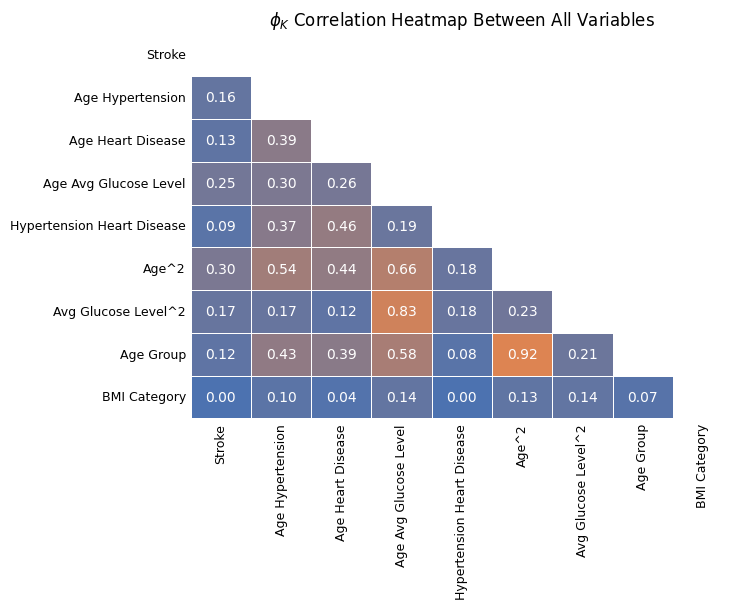

In [27]:
phik_heatmap(patients_new_features.iloc[:, 10:])

Observations:
- All of the engineered features except for BMI category are predictive.
- Very possible duplicated information.

Impact:
- Eliminate BMI category.

VIF measurement for multicollinearity:

In [28]:
patients_new_features.drop(columns="BMI Category", inplace=True)
vif(patients_new_features, "Stroke")

,Feature,VIF
0,const,25.91
1,Age,624779.49
2,Avg Glucose Level,330325.75
3,BMI,1.08
4,Age Hypertension,1.25
5,Age Heart Disease,1.41
6,Age Avg Glucose Level,1044871918.12
7,Hypertension Heart Disease,1.49
8,Age^2,255419606.67
9,Avg Glucose Level^2,694245111.64


Obseravtions:
- As expected, a lot of the new features may not contribute for better predictions.

Impact:
- Keep all of the new information and make sure to address model complexity and multicollinearity with regularization when building the models.
- Conclusion on the usefulness of feature engineering will be drawn after assessing different model performances.

## Summary

Eight new features have been engineered using commonly used methods: interactions, higher order tems and categorization. After evaluating their predictive power, one feature ("BMI category") was eliminated as it was not predictive. The assessment of whether or not these efforts were beneficial will be at the end of Machine Learning section. No preprocessing pipeline was created, because, as we will see, the new features are not necessary.

# Machine Learning

The main objectives for this part of the notebook are:

- Test different algorithms with different class imbalance techniques, both with and without engineered features.
- Tune hyperparameters of the selected models.
- Evaluate the best chosen model on unseen data.

To evaluate model effectiveness, I have chosen the PR AUC score. While both PR AUC and F1 are suitable for imbalanced datasets, the F1 score evaluates the balance between precision and recall at a single threshold. In contrast, PR AUC provides a more informative assessment by considering all possible thresholds.

Results will be discussed at the end of each subsection.


## Baseline with Dummy Classifier

In [29]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
scoring = {
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score, pos_label=1),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True),
    "pr_auc": make_scorer(average_precision_score, pos_label=1),
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
}
X = patients.drop(columns="Stroke")
y = patients["Stroke"]
y_encoded = LabelEncoder().fit_transform(y)
strategies = ["stratified", "most_frequent", "prior", "uniform"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
results = []
for strategy in strategies:
    dummy_clf = DummyClassifier(strategy=strategy)
    cv_scores = cross_validate(
        dummy_clf, X, y_encoded, cv=cv, scoring=scoring, return_train_score=True
    )
    result = {
        "model": strategy,
        "pr_auc": cv_scores["test_pr_auc"].mean(),
        "roc_auc": cv_scores["test_roc_auc"].mean(),
        "f1": cv_scores["test_f1"].mean(),
        "precision": cv_scores["test_precision"].mean(),
        "recall": cv_scores["test_recall"].mean(),
        "validation_accuracy": cv_scores["test_accuracy"].mean(),
        "train_accuracy": cv_scores["train_accuracy"].mean(),
    }
    results.append(result)
dummy_results = pd.DataFrame(results).set_index("model")
dummy_results.index.name = None
dummy_results

,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
stratified,0.07,0.49,0.08,0.08,0.09,0.87,0.87
most_frequent,0.07,0.50,0.00,0.00,0.00,0.93,0.93
prior,0.07,0.50,0.00,0.00,0.00,0.93,0.93
uniform,0.06,0.50,0.10,0.06,0.40,0.49,0.50


Observations:
- Uniform dummy classifier has the highest metrics. Most models will surpass them.

## Model Selection

Data preprocessing includes log transformation and scaling for numeric features and one-hot encoding for categorical features. To avoid the "dummy variable trap," one category from each categorical variable is dropped for linear and SVM models. Pipelines with these steps also include PCA to get an initial good estimate of each model's performance. Models will eventually be built using the original features with regularization to maintain interpretability. To address class imbalance, sample weights will be applied, and SMOTE will be tested, despite concerns about synthetic data. Models will be evaluated using cross-validation with metrics such as accuracy, F1, ROC AUC, PR AUC, precision, and recall. The final model selection will be based on the highest PR AUC.

Original features and weights:

In [30]:
balance_ratio = y.value_counts().iloc[0] / y.value_counts().iloc[1]
balanced_weights = [1, balance_ratio]
models_weighted = {
    "SVM": SVC(probability=True, class_weight="balanced"),
    "KNN": KNeighborsClassifier(weights="distance"),
    "LogisticRegression": LogisticRegression(class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=5, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=5),
    "XGBoost": XGBClassifier(random_state=5, scale_pos_weight=balance_ratio),
    "CatBoost": CatBoostClassifier(
        random_state=5, class_weights=balanced_weights, verbose=0
    ),
    "LightGBM": LGBMClassifier(random_state=5, class_weight="balanced", verbose=0),
}
algorithm_selection_pca_weighted(X, y_encoded, models_weighted)

,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
SVM,0.11,0.72,0.22,0.14,0.57,0.72,0.76
KNN,0.07,0.55,0.04,0.10,0.03,0.92,1.00
LogisticRegression,0.12,0.76,0.24,0.14,0.73,0.68,0.68
RandomForest,0.07,0.69,0.02,0.12,0.01,0.93,1.00
GradientBoosting,0.10,0.72,0.21,0.15,0.39,0.80,0.89
XGBoost,0.07,0.65,0.07,0.09,0.06,0.90,1.00
CatBoost,0.08,0.68,0.13,0.12,0.15,0.87,0.98
LightGBM,0.07,0.67,0.09,0.10,0.07,0.89,1.00


Original features and SMOTE:

In [31]:
models_smote = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(random_state=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=5),
    "XGBoost": XGBClassifier(random_state=5),
    "CatBoost": CatBoostClassifier(random_state=5, verbose=0),
    "LightGBM": LGBMClassifier(random_state=5, verbose=0),
}
algorithm_selection_pca_smote(X, y_encoded, models_smote)

,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
SVM,0.09,0.68,0.17,0.11,0.36,0.77,0.83
KNN,0.08,0.59,0.15,0.10,0.32,0.76,0.86
LogisticRegression,0.12,0.75,0.24,0.14,0.72,0.68,0.68
RandomForest,0.08,0.67,0.12,0.11,0.13,0.87,1.00
GradientBoosting,0.09,0.68,0.20,0.13,0.38,0.79,0.86
XGBoost,0.08,0.65,0.14,0.12,0.16,0.87,1.00
CatBoost,0.07,0.65,0.12,0.10,0.15,0.84,0.97
LightGBM,0.08,0.65,0.15,0.13,0.18,0.86,0.99


Additional features and weights:

In [32]:
X_with_new_features = patients_new_features.drop(columns="Stroke")
algorithm_selection_pca_weighted(X_with_new_features, y_encoded, models_weighted)

,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
SVM,0.12,0.73,0.24,0.15,0.58,0.75,0.78
KNN,0.07,0.58,0.05,0.15,0.03,0.92,1.00
LogisticRegression,0.12,0.76,0.24,0.15,0.70,0.70,0.71
RandomForest,0.07,0.70,0.02,0.10,0.01,0.93,1.00
GradientBoosting,0.11,0.72,0.24,0.17,0.43,0.82,0.89
XGBoost,0.08,0.69,0.12,0.18,0.10,0.91,1.00
CatBoost,0.09,0.72,0.18,0.18,0.18,0.89,0.99
LightGBM,0.08,0.71,0.11,0.15,0.09,0.90,1.00


Additional features and SMOTE:

In [33]:
algorithm_selection_pca_smote(X_with_new_features, y_encoded, models_smote)

,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
SVM,0.11,0.70,0.24,0.15,0.52,0.77,0.81
KNN,0.09,0.63,0.17,0.11,0.38,0.75,0.85
LogisticRegression,0.12,0.76,0.24,0.15,0.71,0.70,0.70
RandomForest,0.08,0.70,0.14,0.14,0.13,0.88,1.00
GradientBoosting,0.09,0.70,0.20,0.14,0.33,0.82,0.90
XGBoost,0.08,0.68,0.12,0.12,0.12,0.88,1.00
CatBoost,0.08,0.68,0.13,0.12,0.14,0.87,0.99
LightGBM,0.08,0.69,0.13,0.13,0.13,0.88,1.00


Observations:
- Of all models tested, logistic regression showed the best performance, followed by gradient boosting.
- Engineered features added a very small improvement, around 0.01 to 0.02.
- SMOTE and weights have very similar outcomes, with weights seemingly slightly better. 

Impact:
- Since the new features add little value, it's better to stick with a simpler model. I will tune the hyperparameters of logistic regression and gradient boosting without the engineered features. However, I'll still check if the effectiveness of logistic regression improves with the new features after tuning.
- Models will use weights to avoid using synthetic data.

*Note from the future*: Instead of gradient boosting, SVM should have been selected. This occurred because I changed how smoking category was handled several times, leading to small performance changes. Since I was nearly done with the project, I decided not to redo for a very small change in performance.

## Model Tuning

Some of the hyperparameter value ranges are small because I refined them over multiple runs, gradually narrowing down to the most effective values. In the end, I didn't present a full range to avoid unnecessary computation time.

Logistic regression with original features:

Best hyperparameters: {'classifier__C': 0.02, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}



,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
Logistic Regression,0.13,0.76,0.24,0.15,0.74,0.68,0.68


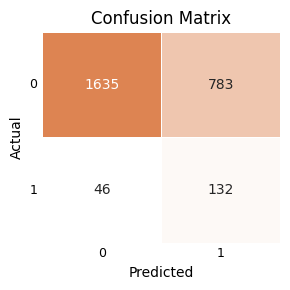

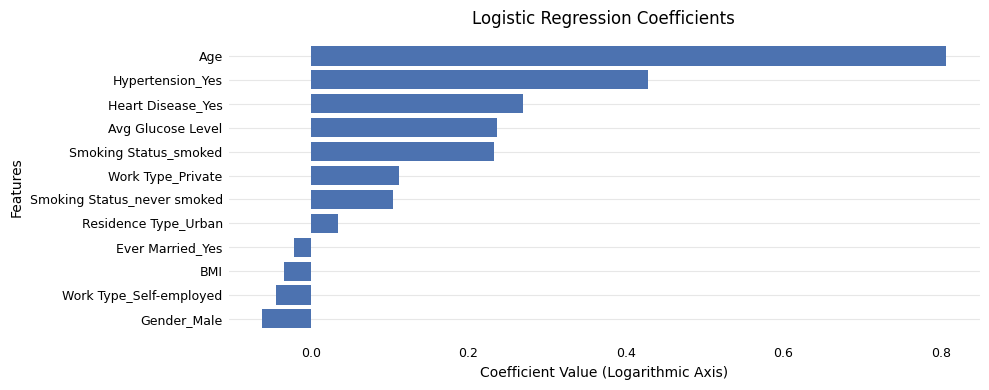

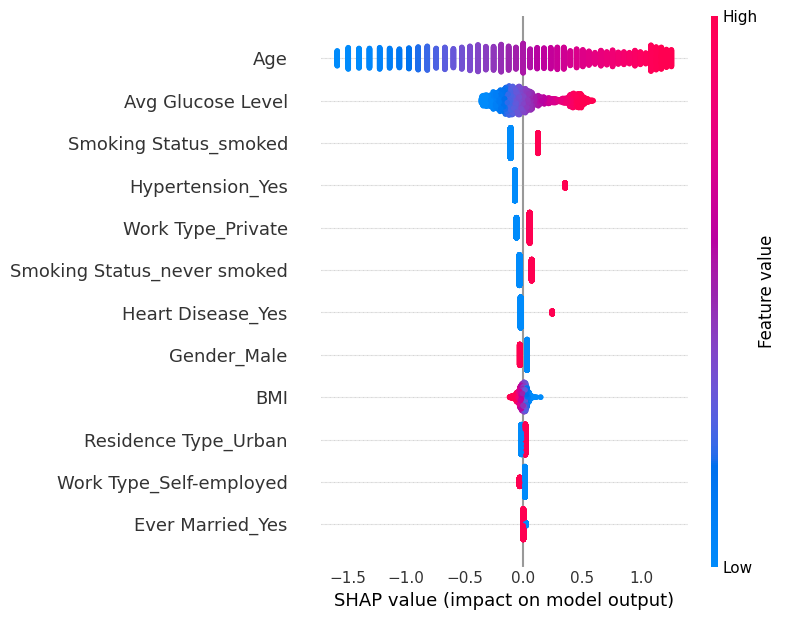

In [34]:
param_grid = [
    {
        "classifier__C": [0.06, 0.07, 0.08],
        "classifier__solver": ["liblinear", "saga"],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["l1"],
    },
    {
        "classifier__C": [0.02, 0.03, 0.04],
        "classifier__solver": ["lbfgs", "saga"],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["l2"],
    },
    {
        "classifier__C": [0.5, 0.6, 0.7],
        "classifier__solver": ["saga"],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["elasticnet"],
        "classifier__l1_ratio": [0.1, 0.5, 0.8],
    },
]

best_pipeline = optimize_logistic_regression(X, y_encoded, param_grid)
joblib.dump(best_pipeline, "trained_model.pkl");

Observations:
- Since this will be the selected model, I will leave a coment on feature importance. Model shows a logical distribution of feature importance, with age, hypertension, heart disease, and average glucose level as the top predictors of stroke, which aligns with their established roles as significant risk factors. However, the positive association of non-smoking with stroke risk is unexpected. Work type has a low coefficient, which is appropriate, as self-employment should not be highly influential. Interestingly, BMI shows a negative influence on stroke risk, whereas it is expected to have a positive impact. The reduced stroke risk associated with being male is not inconsistent with existing research.

Gradient boosting with original features:

Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}



,pr_auc,roc_auc,f1,precision,recall,validation_accuracy,train_accuracy
Gradient Boosting,0.09,0.57,0.17,0.11,0.41,0.72,0.73


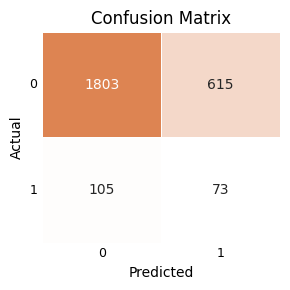

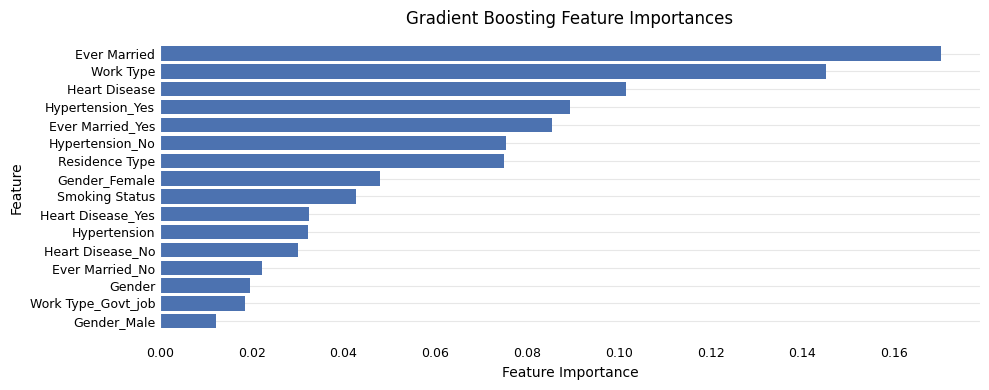

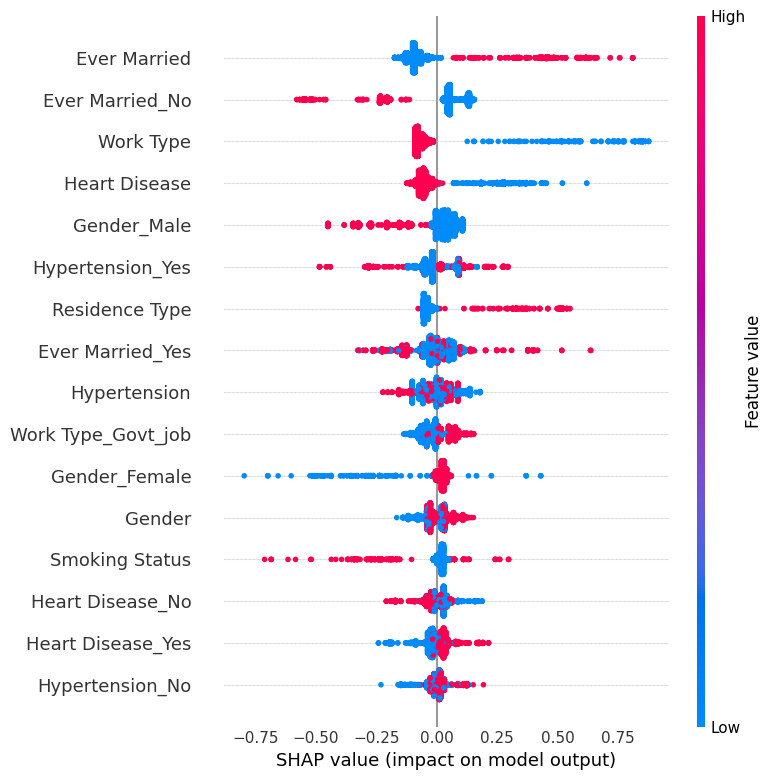

In [36]:
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 4],
    "classifier__min_samples_split": [2, 3],
    "classifier__min_samples_leaf": [3, 4],
}
numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(include="category").columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
    ]
)
pipeline_gradient_boosting = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=5)),
    ]
)
grid_search = GridSearchCV(
    estimator=pipeline_gradient_boosting,
    param_grid=param_grid,
    cv=cv,
    scoring="average_precision",
)
grid_search.fit(X, y_encoded)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}\n")
best_pipeline = grid_search.best_estimator_
sample_weights = compute_sample_weight(class_weight="balanced", y=y_encoded)
cv_scores = cross_validate(
    best_pipeline,
    X,
    y_encoded,
    cv=cv,
    scoring=scoring,
    fit_params={"classifier__sample_weight": sample_weights},
    return_train_score=True,
)
result = {
    "model": "Gradient Boosting",
    "pr_auc": cv_scores["test_pr_auc"].mean(),
    "roc_auc": cv_scores["test_roc_auc"].mean(),
    "f1": cv_scores["test_f1"].mean(),
    "precision": cv_scores["test_precision"].mean(),
    "recall": cv_scores["test_recall"].mean(),
    "validation_accuracy": cv_scores["test_accuracy"].mean(),
    "train_accuracy": cv_scores["train_accuracy"].mean(),
}
results_df = pd.DataFrame([result]).set_index("model")
results_df.index.name = None
display(results_df)

y_pred = cross_val_predict(
    best_pipeline,
    X,
    y_encoded,
    cv=cv,
    fit_params={"classifier__sample_weight": sample_weights},
)
plot_confusion(y_encoded, y_pred)

preprocessor_returned = best_pipeline.named_steps["preprocessor"]
ohe = preprocessor_returned.named_transformers_["cat"]
categorical_features = ohe.get_feature_names_out(categorical_features)
numeric_features = preprocessor_returned.transformers[0][2]
feature_names = np.concatenate([numeric_features, categorical_features])
feature_importances = best_pipeline.named_steps["classifier"].feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 4))
plt.barh(
    np.arange(len(sorted_feature_importances)), sorted_feature_importances, zorder=2
)
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Gradient Boosting Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

classifier = best_pipeline.named_steps["classifier"]
X_transformed = preprocessor_returned.transform(X)
explainer = shap.Explainer(classifier, X_transformed)
shap_values = explainer(X_transformed)
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

Logistic regression with additional features:

In [ ]:
param_grid = [
    {
        "classifier__C": [0.005, 0.01, 0.02],
        "classifier__solver": ["liblinear", "saga"],
        "classifier__max_iter": [80000],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["l1"],
    },
    {
        "classifier__C": [0.005, 0.01, 0.02],
        "classifier__solver": ["lbfgs", "saga"],
        "classifier__max_iter": [20000],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["l2"],
    },
    {
        "classifier__C": [0.005, 0.01, 0.02],
        "classifier__solver": ["saga"],
        "classifier__max_iter": [20000],
        "classifier__class_weight": ["balanced"],
        "classifier__penalty": ["elasticnet"],
        "classifier__l1_ratio": [0.1, 0.3, 0.5],
    },
]
optimize_logistic_regression(X_with_new_features, y_encoded, param_grid);

Observations:
- All models perform similarly, with logistic regression slightly ahead.
- The differences between the models are so small that they may fall within the margin of error, meaning any of them could outperform the others on new unseen data due to variability.
- If the smoking feature is removed, gradient boosting performs slightly better.
- Logistic regression with additional features selects all interactions with age as the most useful. However, this does not improve performance and only adds complexity to interpretation.
- Additional features have little use.

Impact:
- Logistic regression with the original features is the most interpretable, with feature importance that reflects real-world associations and minimal complexity. This model will be selected for deployment.

## Final Model Testing

In [ ]:
loaded_pipeline = joblib.load("trained_model.pkl")
patients_holdout_test_prepared = additional_data_preparation(
    data_preparation(patients_holdout_test)
)
X_holdout_test = patients_holdout_test_prepared.drop(columns="Stroke")
y_holdout_test = patients_holdout_test_prepared["Stroke"]
y_holdout_test_encoded = LabelEncoder().fit_transform(y_holdout_test)
y_pred = loaded_pipeline.predict(X_holdout_test)
y_pred_prob = loaded_pipeline.predict_proba(X_holdout_test)[:, 1]
result = {
    "model": "Logistic Regression",
    "pr_auc": average_precision_score(y_holdout_test_encoded, y_pred_prob),
    "roc_auc": roc_auc_score(y_holdout_test_encoded, y_pred_prob),
    "f1": f1_score(y_holdout_test_encoded, y_pred),
    "precision": precision_score(y_holdout_test_encoded, y_pred),
    "recall": recall_score(y_holdout_test_encoded, y_pred),
    "test_accuracy": accuracy_score(y_holdout_test_encoded, y_pred),
}
results_df = pd.DataFrame([result]).set_index("model")
results_df.index.name = None
display(results_df)
plot_confusion(y_holdout_test_encoded, y_pred)
plot_final_evaluation_curves(y_holdout_test_encoded, y_pred_prob)

Observations:
- As expected, an unbiased evaluation of the model's efficiency on unseen data shows that the scores are lower to those obtained on the training data.
- The final test performance shows a higher PR AUC than before, but this is reasonable due to differences in dataset distributions.

# Conclusions

Further possible refinements and changes:

- Investigate Misclassifications: Analyze instances where the model made incorrect predictions. Consider removing or adjusting data points that may be outliers or introduce noise.
- Drop Smoking Feature: I have tested and this variable did not add predictive power. Removing it is an option for simplification without sacrificing performance.
- Class Imbalance: Instead of using weights, try taking a random sample from the majority class.
- Domain Knowledge-Based Feature Selection: Exclude residence and work type data from the model. I have tested this, and removing these two features does not change linear regression performance and feature importance makes more sense, as having a high BMI starts to show a positive influence on the likelihood of stroke.
- Eliminate Non-Predictive Features Based on EDA: The model currently includes all features, but I could refine it by including only those found to have a statistically significant contribution. This would exclude gender and residence type.
- Experiment with Ordinal Encoding: Instead of one-hot encoding, try ordinal encoding for engineered features to see if it enhances model performance.
- Consider Gradient Boosting as the final model: Currently, Gradient Boosting performs worse than Logistic Regression. However, implementing some of the feature selection options described above can slightly improve its performance, exceeding that of Logistic Regression, though this improvement may be within the margin of error due to data variability.